# Analyse Sentiments de Twitters Français.

Ce Notebook a pour but la mise en place d'un modèle / IA de Deep Learning (Réseaux RNN/LSTM, Word Embeddings) pour permettre de classifer un tweet en Positif ou Négatif. Pour cela on utilise les données issue de Kaggle  [french-twitter-sentiment-analysis](https://www.kaggle.com/hbaflast/french-twitter-sentiment-analysis). 

Le Dataset est constitué de deux colonnes Label qui un entier `0` représente un Tweet Négatif and `1` réprésente lui un Tweet Positif. Et du text du tweet. 

# Charger les librairies nécessaires

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.4.0'

In [3]:
# Basic Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing utisant NTLK et Preprocessing de Tensorflow
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and Read the CVS file as a DataFrame.

In [4]:
df = pd.read_csv('./french_tweets.csv')
df.head(6)

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."
5,0,Pas l'équipage complet


# Distribution des deux sentiments 

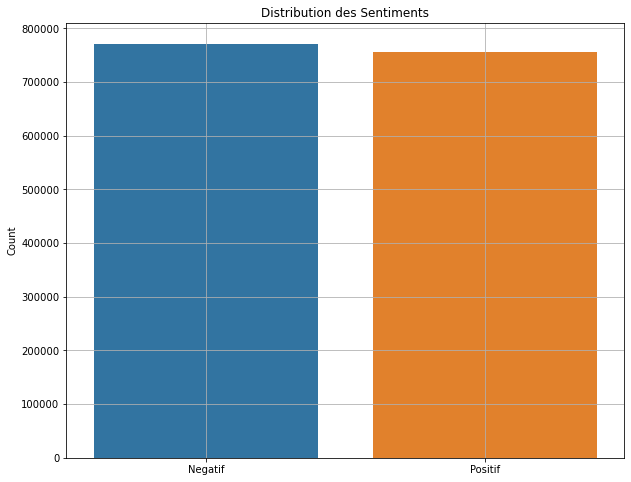

In [5]:
df['Sentiment'] = df['label'].apply(lambda v: 'Positif' if v == 1 else 'Negatif')

plt.figure(figsize=(10, 8))
ax=sns.countplot(x="Sentiment", data=df)
plt.xlabel('')
plt.ylabel('Count')
plt.title("Distribution des Sentiments")
plt.grid()
plt.show()

In [6]:
def filter_sentiments(sentiment:int):
  return df[df['label'] == sentiment]['text'].str.cat(sep=' ')

# WordCloud

In [ ]:
def show_wordcloud(sentiment:int, title:str):
  sentiments = filter_sentiments(sentiment=sentiment)
  wordcloud = WordCloud().generate(sentiments)
  plt.figure(figsize=(15, 20))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title)
  plt.show()
  return sentiments

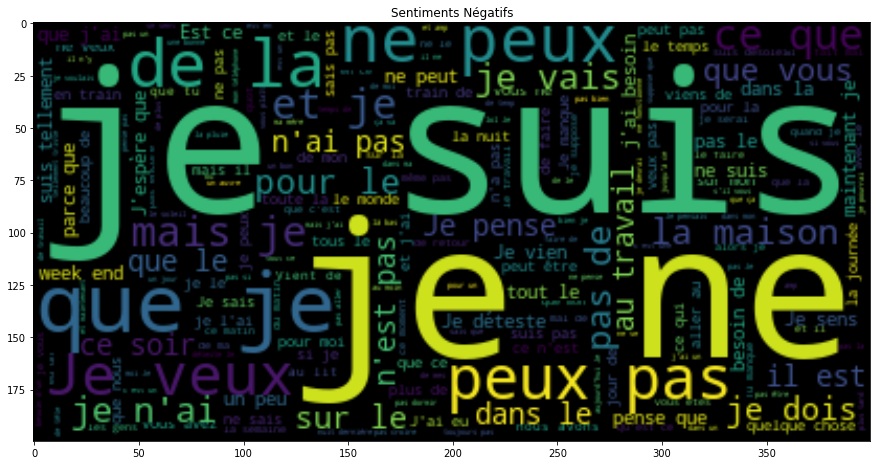

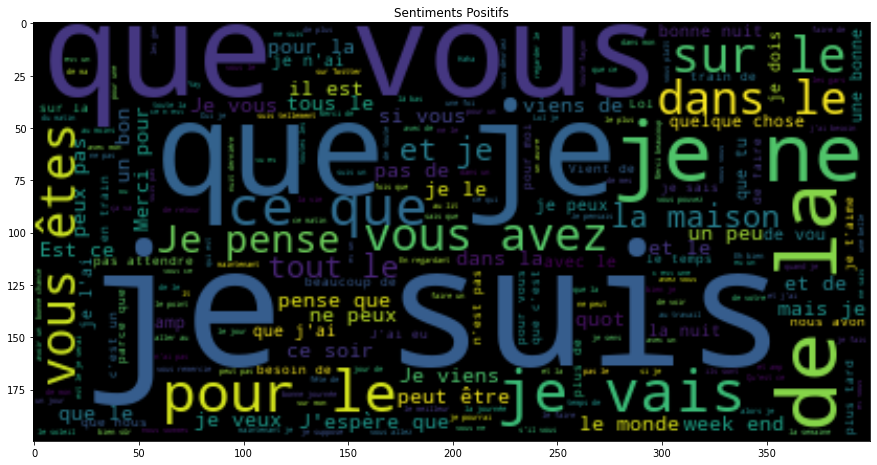

In [ ]:
show_wordcloud(sentiment=0, title='Sentiments Négatifs')
show_wordcloud(sentiment=1, title='Sentiments Positifs')

# Distribution des tailles des mots des sentiments

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Moyenne de la taille des mots')

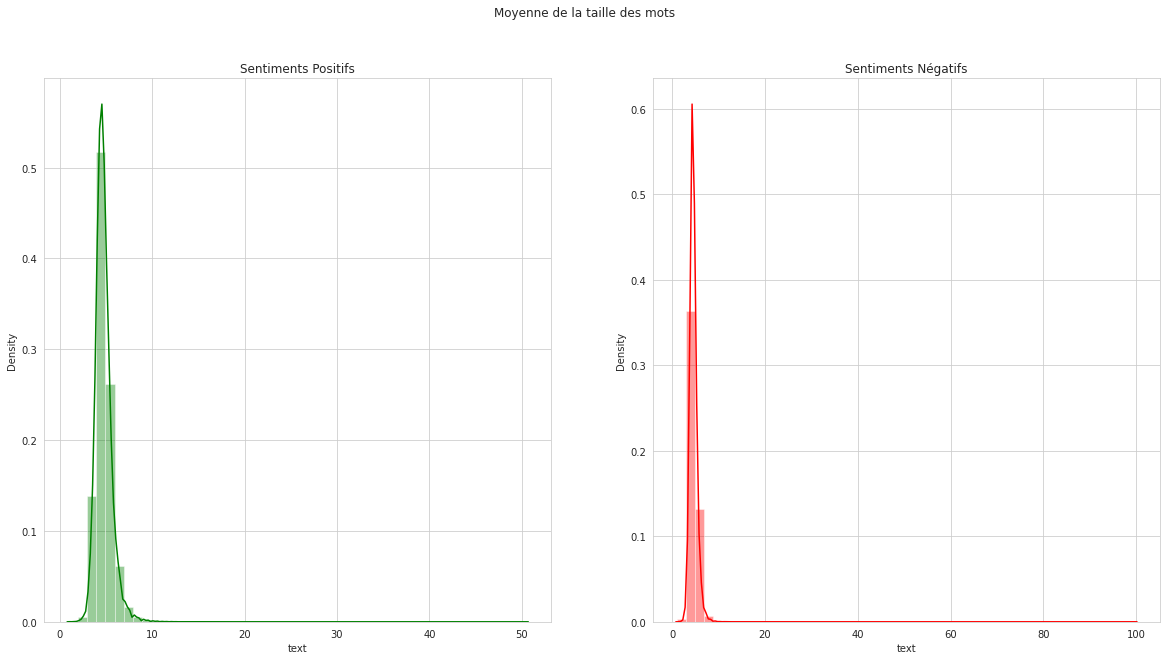

In [ ]:
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(20,10))
plt.grid()
word=df[df['label']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.set_style("whitegrid")
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Sentiments Négatifs')

plt.grid()
word=df[df['label']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.set_style("whitegrid")
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Sentiments Positifs')


fig.suptitle('Moyenne de la taille des mots')

# Fréquence des mots

## Fréquence des mots des tweets positifs

In [7]:
sentiments_positifs = filter_sentiments(sentiment=1)
sentiments_positifs_freq = nltk.FreqDist(sentiments_positifs.split())
pd.DataFrame(sentiments_positifs_freq.most_common(), columns=['Word', 'Frequency'])

,Word,Frequency
0,de,354862
1,le,182484
2,je,170297
3,à,165092
4,la,162301
...,...,...
401265,"principal""",1
401266,Thewdb.com,1
401267,Walt!,1
401268,8bmta,1


## Fréquence des mots des tweets négatifs

In [8]:
sentiments_negatifs = filter_sentiments(sentiment=0)
sentiments_negatifs_freq = nltk.FreqDist(sentiments_negatifs.split())
pd.DataFrame(sentiments_negatifs_freq.most_common(), columns=['Word', 'Frequency'])

,Word,Frequency
0,de,397477
1,je,258033
2,pas,226885
3,Je,200548
4,à,190286
...,...,...
357723,Youuuuu?,1
357724,smaat,1
357725,zta,1
357726,caro.,1


# Fonction de cleaning et préprocessing du text

In [7]:
# Download the nlk stopword
nltk.download('stopwords')
stop = set(stopwords.words('french'))

from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
    
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Remove not need tweet tags : RT, @, #
def remove_tags(text):
    cleaned = re.sub(r'#', '', text)
    cleaned=re.sub(r'^RT[\s]+', '', cleaned)
    return re.sub(r'@', '', cleaned)

def remove_numeric(text):
  return re.sub(r'[0-9]', '', text)

def to_stemmer(text):
   words=[]
   for word in text.split():
      stem_word = stemmer.stem(word) 
      words.append(stem_word)
   return " ".join(words)

def pre_processing(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = remove_tags(text)
    text = remove_numeric(text)
    text = to_stemmer(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df['cleaned_text']=df['text'].apply(pre_processing)

C:\Users\Salem\anaconda4\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: ". . ." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [9]:
df.head()

,label,text,Sentiment,cleaned_text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi...",Negatif,"- awww, c'est bummer. devr avoir david carr tr..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...,Negatif,contrari qu'il puiss mettr jour facebook télém...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...,Negatif,j'ai plong plusieur fois balle. a réuss économ...
3,0,Tout mon corps a des démangeaisons et comme si...,Negatif,tout corp a démangeaison comm si c'et feu
4,0,"Non, il ne se comporte pas du tout. je suis en...",Negatif,"non, comport tout. colère. pourquoi suis-j ici..."


## Vectorisation: Tokenizing & Padding

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=280

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

X_data, tokenizer = tokenize_pad_sequences(df['cleaned_text'])


In [11]:
X_data

array([[ 449,    3, 2357, ...,    0,    0,    0],
       [1908,   35,  353, ...,    0,    0,    0],
       [   1, 3281, 1187, ...,    0,    0,    0],
       ...,
       [ 273,   47,  191, ...,    0,    0,    0],
       [ 557,   20,  280, ...,    0,    0,    0],
       [ 343,  368,  383, ...,    0,    0,    0]])

In [12]:
X_data.shape

(1526724, 280)

In [13]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Architecture Deep Learning, utilisant Keras/Tensorflow

## Import des librairies nécessaires

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM, GRU, GlobalMaxPool1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import os

## Split to Train and Valid Set

In [15]:
target = df.label
x_train, x_valid, y_train, y_valid = train_test_split(X_data, target, test_size =0.3, random_state = 42, stratify=target)

# Fonctions Helpers

## Plot du Training vs Validation


In [16]:
def plot_graphs(history, string, title):
  plt.figure(figsize=(8, 8))
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.title(title)
  plt.legend([string, 'val_'+string])
  plt.grid()
  plt.show()

## Metrics

In [17]:
def showMetrics(model, x_valid, y_valid, title):
  y_pred = model.predict_classes(x_valid)
  cm = confusion_matrix(y_valid, y_pred)
  cm = pd.DataFrame(
    cm, 
    index=['Négatif','Positif'], 
    columns = ['Négatif','Positif']
  )
  plt.figure(figsize = (10,10))
  plt.title(title)
  sns.heatmap(cm, 
            cmap="Blues", 
            linecolor='black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Négatifs','Positifs'],
            yticklabels = ['Négatifs','Positifs']
  )
  plt.show()
  from sklearn.metrics import classification_report
  classification_report = classification_report(y_true=y_valid, y_pred = y_pred)
  print('Classification Report')
  print(classification_report)

## Optimizer

In [ ]:
# ADAM = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#ADAM = tf.keras.optimizers.Adam(learning_rate=0.0001)

## Entrainer un modèle donné

In [18]:
def fitModel(model, epochs):
  # Train and Fit
  history = model.fit(x_train, y_train, epochs=epochs, verbose=1, 
                    validation_data=(x_valid, y_valid))
     
  return history

## Modèle RNN/LSTM

In [19]:
# Taille du Vocabulaire
len(set(tokenizer.word_index))

245672

In [20]:
epochs = 30
def buildLSTMModel():    
  vocab_size = 5000
  embedding_size = 32
  learning_rate = 0.1
  decay_rate = learning_rate / epochs
  momentum = 0.8

  sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
  
  # Build model
  model= Sequential()
  model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
 
  
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 

  model.summary()
  return model

In [21]:
# Create LSTM Model
lstm_model = buildLSTMModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 32)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 140, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 212,897
Trainable params: 212,897
Non-trainable params: 0
__________________________________________________

In [22]:
# Fit the Model 
history = fitModel(model=lstm_model, epochs=epochs)

Epoch 1/30
33398/33398 [==============================] - 3425s 102ms/step - loss: 0.5814 - accuracy: 0.6784 - val_loss: 0.5024 - val_accuracy: 0.7597
Epoch 2/30
33398/33398 [==============================] - 3381s 101ms/step - loss: 0.5017 - accuracy: 0.7599 - val_loss: 0.4955 - val_accuracy: 0.7623
Epoch 3/30
33398/33398 [==============================] - 3350s 100ms/step - loss: 0.4943 - accuracy: 0.7644 - val_loss: 0.4925 - val_accuracy: 0.7644
Epoch 4/30
33398/33398 [==============================] - 3429s 103ms/step - loss: 0.4913 - accuracy: 0.7657 - val_loss: 0.4911 - val_accuracy: 0.7641
Epoch 5/30
33398/33398 [==============================] - 3421s 102ms/step - loss: 0.4888 - accuracy: 0.7673 - val_loss: 0.4897 - val_accuracy: 0.7652
Epoch 6/30
33398/33398 [==============================] - 3422s 102ms/step - loss: 0.4889 - accuracy: 0.7667 - val_loss: 0.4889 - val_accuracy: 0.7656
Epoch 7/30
33398/33398 [==============================] - 3431s 103ms/step - loss: 0.4877 - ac

## Evaluation du Modèle LSTM

C:\Users\Salem\anaconda4\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


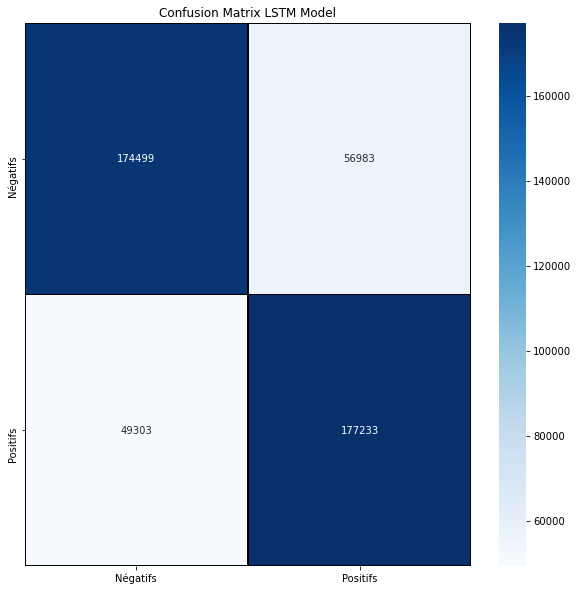

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    231482
           1       0.76      0.78      0.77    226536

    accuracy                           0.77    458018
   macro avg       0.77      0.77      0.77    458018
weighted avg       0.77      0.77      0.77    458018



In [23]:
# Evaluer Accuracy, F1 Score...
showMetrics(lstm_model, x_valid=x_valid, y_valid=y_valid, title='Confusion Matrix LSTM Model')

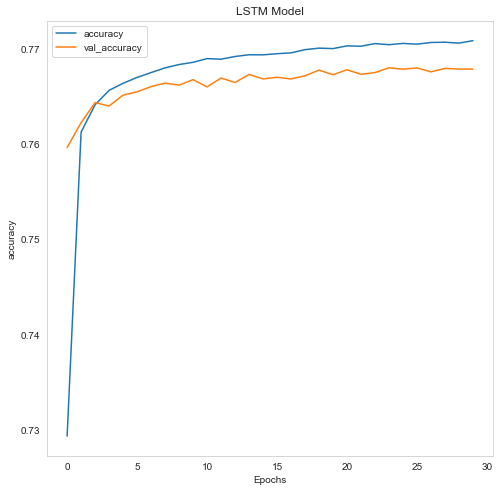

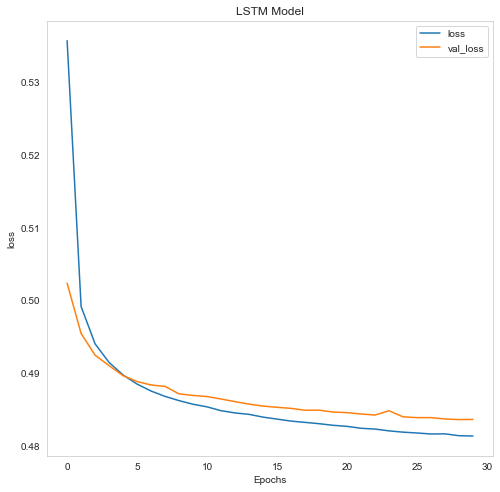

In [24]:
# Plot Loss and Accuracy for Training and Validation
sns.set_style('whitegrid')
plot_graphs(history, "accuracy", 'LSTM Model')
plot_graphs(history, "loss", 'LSTM Model')

## Sauvegarde du Modèle

In [25]:
DESTINATION = "./LSTM"
if not os.path.exists(DESTINATION):
  os.makedirs(DESTINATION)

lstm_model.save(f'./{DESTINATION}')

INFO:tensorflow:Assets written to: ././LSTM\assets


INFO:tensorflow:Assets written to: ././LSTM\assets


## Exporter les modèles au format Zip

In [26]:
from shutil import make_archive
make_archive(DESTINATION,'zip', root_dir=f'{DESTINATION}')

'D:\\Project\\V4\\LSTM.zip'